In [20]:
# ==============================================================================
# CELL 1: CÀI ĐẶT, IMPORTS & THIẾT LẬP BAN ĐẦU
# ==============================================================================
import os
import json
import asyncio
from typing import TypedDict, Annotated, List, Dict, Any, Literal, Optional
import operator

# Tải các biến môi trường
from dotenv import load_dotenv
load_dotenv()

# LangChain & LangGraph
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, END

# Thư viện hỗ trợ
from rich.console import Console
from rich.markdown import Markdown
from IPython.display import Image, display

VERBOSE_MODE = False
# --- Khởi tạo các đối tượng dùng chung ---
console = Console()

def print_markdown(text):
    """Hàm tiện ích để in markdown ra console."""
    console.print(Markdown(text))

# Khởi tạo LLM
try:
    llm = ChatGroq(
        temperature=0.1,
        model="llama3-70b-8192",
        api_key=os.getenv("GROQ_API_KEY"),
        max_tokens=2048
    )
    print("✅ LLM (Groq) đã được khởi tạo thành công.")
except Exception as e:
    print(f"❌ LỖI: Không thể khởi tạo LLM. Lỗi: {e}")
    llm = None

✅ LLM (Groq) đã được khởi tạo thành công.


In [21]:
# ==============================================================================
# CELL 1.5: TẢI KHO TRI THỨC RAG ĐÃ XỬ LÝ SẴN
# ==============================================================================
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings

# --- CẤU HÌNH ---
VECTOR_STORE_PATH = "vector_store/sgk_toan_9"
EMBEDDING_MODEL = "all-MiniLM-L6-v2"

# --- HÀM TẢI KHO TRI THỨC ---
def load_vector_store():
    """Tải kho tri thức đã được xây dựng từ local."""
    if not os.path.exists(VECTOR_STORE_PATH):
        print(f"❌ LỖI: Không tìm thấy kho tri thức tại '{VECTOR_STORE_PATH}'.")
        print("Vui lòng chạy file 'build_knowledge_base.py' trước để tạo kho tri thức.")
        return None
    
    try:
        print(f"✅ Đang tải kho tri thức từ: {VECTOR_STORE_PATH}...")
        embeddings = HuggingFaceEmbeddings(model_name=EMBEDDING_MODEL)
        db = FAISS.load_local(VECTOR_STORE_PATH, embeddings, allow_dangerous_deserialization=True)
        print("🎉 Tải kho tri thức thành công!")
        return db
    except Exception as e:
        print(f"❌ LỖI khi tải kho tri thức: {e}")
        return None

# --- TẢI VÀ SỬ DỤNG ---
vector_store = load_vector_store()

✅ Đang tải kho tri thức từ: vector_store/sgk_toan_9...
🎉 Tải kho tri thức thành công!


In [39]:
# ==============================================================================
# CELL 2: ĐỊNH NGHĨA STATE CHO HỆ THỐNG (PHIÊN BẢN CUỐI CÙNG)
# ==============================================================================
from langgraph.graph.message import add_messages # <-- Import add_messages ở đây

# --- Hàm tiện ích ---
def merge_dicts(dict1: Dict[str, Any], dict2: Dict[str, Any]) -> Dict[str, Any]:
    merged = dict1.copy()
    for key, value in dict2.items():
        if key in merged and isinstance(merged[key], dict) and isinstance(value, dict):
            merged[key] = merge_dicts(merged[key], value)
        else:
            merged[key] = value
    return merged

# --- Định nghĩa các cấu trúc dữ liệu con ---
class AnalyzedObjective(TypedDict):
    action_verb: str
    bloom_level: int
    topic: str
    grade_level: str
    constraints: List[str]

class PedagogyStrategy(TypedDict):
    chosen_pedagogy: str
    pedagogy_rationale: str
    suggested_structure: List[Dict[str, Any]]

class Task(TypedDict):
    task_id: int
    task_name: str
    task_description: str
    status: Literal["pending", "completed"]

# --- Định nghĩa State chính (phiên bản hoàn chỉnh nhất) ---
class TeacherState(TypedDict):
    # Dùng add_messages là cách làm đúng chuẩn cho kênh messages
    messages: Annotated[List[BaseMessage], add_messages]
    
    analyzed_objective: Optional[AnalyzedObjective]
    pedagogy_strategy: Optional[PedagogyStrategy]
    task_list: Optional[List[Task]]
    current_task_id: Optional[int]
    
    # Dùng merge_dicts để các agent không ghi đè kết quả của nhau
    agent_outputs: Annotated[Dict[str, Any], merge_dicts] 
    
    final_lesson_plan: Optional[str]
    
    # Kênh này dùng để điều phối, không cần decorator đặc biệt
    next_agent: str

print("✅ 'TeacherState' (phiên bản cuối cùng) đã được định nghĩa.")

✅ 'TeacherState' (phiên bản cuối cùng) đã được định nghĩa.


In [40]:
# ==============================================================================
# CELL 3: XÂY DỰNG CÁC AGENT (PHIÊN BẢN SỬA LỖI VÒNG LẶP)
# ==============================================================================
import json
from langchain_core.pydantic_v1 import BaseModel, Field

# --- Các class định nghĩa cấu trúc ---
class ParsedObjective(BaseModel):
    action_verb: str = Field(description="Động từ hành động chính, ví dụ: 'phân tích', 'trình bày'.")
    bloom_level: int = Field(description="Cấp độ tư duy theo thang Bloom (1-6).")
    topic: str = Field(description="Chủ đề chính của bài học.")
    grade_level: str = Field(description="Cấp lớp của học sinh, ví dụ: 'Lớp 9'.")

class PedagogyChoice(BaseModel):
    chosen_pedagogy: str = Field(description="Tên phương pháp sư phạm được chọn.")
    pedagogy_rationale: str = Field(description="Lý do tại sao phương pháp này lại phù hợp.")

class TaskList(BaseModel):
    tasks: List[Dict[str, str]] = Field(description="Danh sách nhiệm vụ, mỗi nhiệm vụ có 'task_name' và 'task_description'.")

class TaskClassification(BaseModel):
    """Phân loại một nhiệm vụ vào đúng danh mục agent."""
    agent_category: Literal["activity_designer", "resource_scout", "assessment_creator", "unknown"] = Field(description="Loại agent nên thực hiện nhiệm vụ này.")

# --- Các agent tuần tự ban đầu ---
async def objective_interpreter_agent(state: TeacherState) -> Dict[str, Any]:
    print_markdown("\n---\n### 🕵️ `Agent: Objective Interpreter` Bắt đầu...")
    user_request = state['messages'][-1].content
    prompt = f"""Bạn là một chuyên gia phân tích yêu cầu giáo dục. Đọc yêu cầu của giáo viên và trích xuất MỤC TIÊU HỌC TẬP THỰC SỰ mà học sinh cần đạt. Bỏ qua các động từ mệnh lệnh ban đầu như "Soạn", "Tạo". Tập trung vào năng lực học sinh.
    THANG ĐO BLOOM: 1-Nhớ, 2-Hiểu, 3-Vận dụng, 4-Phân tích, 5-Đánh giá, 6-Sáng tạo.
    YÊU CẦU: "{user_request}" """
    structured_llm = llm.with_structured_output(ParsedObjective)
    parsed_result = await structured_llm.ainvoke(prompt)
    analyzed_objective_dict = parsed_result.dict()
    analyzed_objective_dict["constraints"] = []
    print_markdown(f"**Kết quả phân tích:**\n```json\n{json.dumps(analyzed_objective_dict, indent=2, ensure_ascii=False)}\n```")
    return {"analyzed_objective": analyzed_objective_dict}

async def pedagogy_strategist_agent(state: TeacherState) -> Dict[str, Any]:
    print_markdown("\n---\n### 🧑‍🏫 `Agent: Pedagogy Strategist` Bắt đầu...")
    objective = state['analyzed_objective']
    prompt = f"""Bạn là một chuyên gia sư phạm. Dựa vào mục tiêu học tập sau, hãy chọn ra một chiến lược dạy học phù hợp nhất.
    LỰA CHỌN: Direct Instruction, Collaborative Learning, Inquiry-Based Learning (IBL), Hybrid Model.
    MỤC TIÊU: {objective}
    Chỉ trả về JSON hợp lệ: {{"chosen_pedagogy": "Tên phương pháp", "pedagogy_rationale": "Lý do"}}"""
    response = await llm.with_structured_output(schema=PedagogyChoice, method="json_mode").ainvoke(prompt)
    pedagogy_strategy_dict = response.dict()
    pedagogy_strategy_dict["suggested_structure"] = []
    print_markdown(f"**Chiến lược:** {response.chosen_pedagogy}\n**Lý do:** {response.pedagogy_rationale}")
    return {"pedagogy_strategy": pedagogy_strategy_dict}

async def plan_delegator_agent(state: TeacherState) -> Dict[str, Any]:
    print_markdown("\n---\n### 👷 `Agent: Plan Delegator` Bắt đầu...")
    objective = state['analyzed_objective']
    strategy = state['pedagogy_strategy']
    prompt = f"""Bạn là quản lý dự án giáo dục. Dựa trên mục tiêu và chiến lược, chia nhỏ công việc tạo giáo án thành một danh sách các nhiệm vụ cụ thể.
    Mục tiêu: {objective['topic']} (Bloom: {objective['bloom_level']})
    Chiến lược: {strategy['chosen_pedagogy']}
    Ví dụ task: 'design_warmup_activity', 'find_resources', 'create_assessment'.
    """
    structured_llm = llm.with_structured_output(TaskList)
    task_list_result = await structured_llm.ainvoke(prompt)
    tasks_with_status = [{"task_id": i, "task_name": t['task_name'], "task_description": t['task_description'], "status": "pending"} for i, t in enumerate(task_list_result.tasks)]
    print_markdown(f"**Đã tạo {len(tasks_with_status)} nhiệm vụ.**")
    return {"task_list": tasks_with_status}

# --- AGENT DISPATCHER THÔNG MINH ---
async def task_dispatcher_agent(state: TeacherState) -> Dict[str, Any]:
    print_markdown("\n---\n### 🚚 `Agent: Task Dispatcher` Bắt đầu...")
    current_task_id = state.get("current_task_id")
    task_list = state.get("task_list", [])
    task_to_run = next((task for task in task_list if task.get("task_id") == current_task_id), None)
    if not task_to_run: return {"next_agent": "mark_task_complete"}

    task_description = task_to_run['task_description']
    prompt = f"""Phân loại nhiệm vụ sau vào agent phù hợp nhất: 'activity_designer', 'resource_scout', 'assessment_creator', hoặc 'unknown'.
    NHIỆM VỤ: "{task_description}" """
    structured_llm = llm.with_structured_output(TaskClassification)
    classification_result = await structured_llm.ainvoke(prompt)
    next_agent = classification_result.agent_category
    if next_agent == "unknown":
        print_markdown(f"--- 🚚 `Dispatcher`: Không nhận ra nhiệm vụ. Bỏ qua.")
        return {"next_agent": "mark_task_complete"}
    print_markdown(f"--- 🚚 `Dispatcher`: Giao nhiệm vụ cho `{next_agent}`.")
    return {"next_agent": next_agent}


# --- AGENT CHUYÊN MÔN VÀ AGENT TỔNG HỢP ---
# (Các agent này giữ nguyên như phiên bản trước, tôi rút gọn để đỡ dài)
def update_agent_outputs(state: TeacherState, key: str, value: Any) -> Dict[str, Any]:
    outputs = state.get("agent_outputs", {}).copy()
    if key not in outputs: outputs[key] = []
    outputs[key].append(value)
    return {"agent_outputs": outputs}

async def activity_designer_agent(state: TeacherState) -> Dict[str, Any]:
    activity = {"name": "Hoạt động Thảo luận Nhóm", "description": "Chia lớp thành 4 nhóm..."}
    return update_agent_outputs(state, "activities", activity)
async def resource_scout_agent(state: TeacherState) -> Dict[str, Any]:
    summary = f"Đây là tóm tắt về '{state['analyzed_objective']['topic']}'."
    resource = {"source": "Sách giáo khoa", "summary": summary}
    return update_agent_outputs(state, "resources", resource)
async def assessment_creator_agent(state: TeacherState) -> Dict[str, Any]:
    assessment = {"question": "Câu hỏi 1: ...?", "type": "multiple_choice"}
    return update_agent_outputs(state, "assessments", assessment)
async def lesson_plan_compiler_agent(state: TeacherState) -> Dict[str, Any]:
    prompt = f"Tổng hợp các thông tin sau thành giáo án Markdown: {state['agent_outputs']}"
    response = await llm.ainvoke(prompt)
    return {"final_lesson_plan": response.content}

print("✅ Tất cả agent (phiên bản v2) đã được định nghĩa.")

✅ Tất cả agent (phiên bản v2) đã được định nghĩa.


✅ Graph (phiên bản v2) đã được biên dịch thành công.


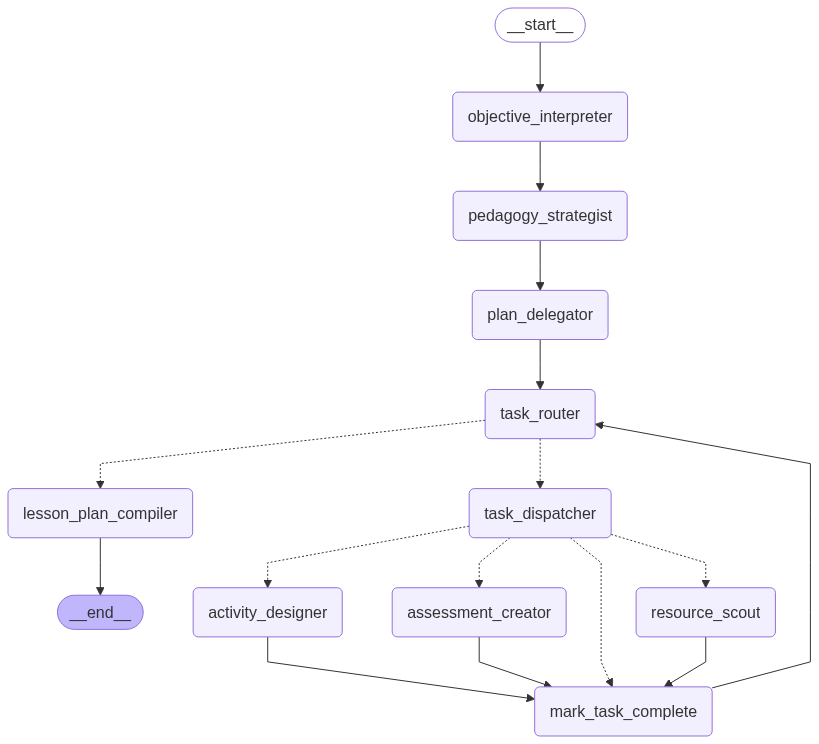

In [41]:
# ==============================================================================
# CELL 4: LẮP RÁP GRAPH (PHIÊN BẢN V2 - SẠCH SẼ & ỔN ĐỊNH)
# ==============================================================================
from langgraph.graph.message import add_messages


# --- Các node tiện ích và router ---
def mark_task_complete(state: TeacherState) -> Dict[str, Any]:
    task_list = state.get("task_list", [])
    current_task_id = state.get("current_task_id")
    if not task_list or current_task_id is None: return {}
    new_task_list = [t.copy() for t in task_list]
    for task in new_task_list:
        if task.get("task_id") == current_task_id:
            task["status"] = "completed"
            break
    return {"task_list": new_task_list, "current_task_id": None}

def task_router_node(state: TeacherState) -> Dict[str, Any]:
    print_markdown("\n---\n### 🚦 `Router`: Đang kiểm tra nhiệm vụ...")
    task_list = state.get("task_list", [])
    next_task = next((task for task in task_list if task.get("status") == "pending"), None)
    if next_task:
        print_markdown(f"--- 🚦 `Router`: Còn nhiệm vụ, đi đến Dispatcher.")
        return {"current_task_id": next_task['task_id'], "next_agent": "task_dispatcher"}
    else:
        print_markdown("--- 🚦 `Router`: Hết nhiệm vụ, đi đến Compiler.")
        return {"next_agent": "lesson_plan_compiler"}

# --- Xây dựng Graph ---
workflow = StateGraph(TeacherState)

# Thêm các node
node_list = [
    ("objective_interpreter", objective_interpreter_agent),
    ("pedagogy_strategist", pedagogy_strategist_agent),
    ("plan_delegator", plan_delegator_agent),
    ("task_router", task_router_node),
    ("task_dispatcher", task_dispatcher_agent),
    ("mark_task_complete", mark_task_complete),
    ("activity_designer", activity_designer_agent),
    ("resource_scout", resource_scout_agent),
    ("assessment_creator", assessment_creator_agent),
    ("lesson_plan_compiler", lesson_plan_compiler_agent)
]
for name, node in node_list:
    workflow.add_node(name, node)

# Kết nối các bước
workflow.set_entry_point("objective_interpreter")
workflow.add_edge("objective_interpreter", "pedagogy_strategist")
workflow.add_edge("pedagogy_strategist", "plan_delegator")
workflow.add_edge("plan_delegator", "task_router")

# Điểm rẽ nhánh sau Router
workflow.add_conditional_edges(
    "task_router",
    lambda state: state["next_agent"],
    {"task_dispatcher": "task_dispatcher", "lesson_plan_compiler": "lesson_plan_compiler"}
)

# Điểm rẽ nhánh sau Dispatcher
workflow.add_conditional_edges(
    "task_dispatcher",
    lambda state: state["next_agent"],
    {
        "activity_designer": "activity_designer",
        "resource_scout": "resource_scout",
        "assessment_creator": "assessment_creator",
        "mark_task_complete": "mark_task_complete"
    }
)

# Vòng lặp
workflow.add_edge("activity_designer", "mark_task_complete")
workflow.add_edge("resource_scout", "mark_task_complete")
workflow.add_edge("assessment_creator", "mark_task_complete")
workflow.add_edge("mark_task_complete", "task_router")

# Kết thúc
workflow.add_edge("lesson_plan_compiler", END)

# Biên dịch
app = workflow.compile()
print("✅ Graph (phiên bản v2) đã được biên dịch thành công.")
display(Image(app.get_graph().draw_mermaid_png()))

In [42]:
# ==============================================================================
# CELL 5: CHẠY THỬ NGHIỆM (PHIÊN BẢN CUỐI CÙNG)
# ==============================================================================

async def run_graph(user_request: str):
    """
    Hàm để chạy graph với một yêu cầu cụ thể, theo dõi các bước,
    và in ra kết quả cuối cùng một cách đẹp mắt.
    """
    
    # Khởi tạo trạng thái ban đầu, đảm bảo các trường cần thiết có giá trị mặc định
    initial_state = {
        "messages": [HumanMessage(content=user_request)],
        "agent_outputs": {},
        # Khởi tạo các trường khác là None để tránh lỗi Key Error
        "analyzed_objective": None,
        "pedagogy_strategy": None,
        "task_list": None,
        "current_task_id": None,
        "final_lesson_plan": None
    }
    
    print_markdown(f"# 🚀 BẮT ĐẦU QUY TRÌNH VỚI YÊU CẦU:\n> {user_request}")
    
    # Cấu hình với giới hạn lặp cao hơn để cho phép nhiều bước thực thi
    config = {"recursion_limit": 25} # Tăng lên 25 để chắc chắn
    
    final_state_result = None
    
    # Sử dụng astream để chạy và theo dõi từng bước
    # Vòng lặp này sẽ stream output của từng node khi nó hoàn thành
    async for event in app.astream(initial_state, config=config):
        # Mỗi event là một dictionary chứa tên node và kết quả (state) sau khi node đó chạy
        for node_name, node_output in event.items():
            print_markdown(f"--- \n### ✅ Hoàn thành bước: `{node_name}`")
            # Chúng ta lưu lại state cuối cùng sau mỗi bước để đảm bảo có kết quả cuối
            final_state_result = node_output 

    print_markdown("\n---\n# 🏁 KẾT THÚC QUY TRÌNH.")
    
    # Sau khi quy trình kết thúc, in ra các thông tin quan trọng
    if final_state_result:
        # In ra giáo án cuối cùng nếu có
        if final_state_result.get("final_lesson_plan"):
            print_markdown("\n---\n# 📝 GIÁO ÁN HOÀN CHỈNH")
            # In nội dung giáo án bằng Markdown để hiển thị đẹp
            print_markdown(final_state_result["final_lesson_plan"])
        
        # In ra toàn bộ state cuối cùng để kiểm tra chi tiết
        print_markdown("\n---\n# 🕵️‍♂️ TRẠNG THÁI CUỐI CÙNG (ĐỂ DEBUG)")
        from pprint import pprint
        # Sử dụng pprint để in dictionary một cách dễ đọc
        pprint(final_state_result)
    else:
        print_markdown("\n---\n### ⚠️ Không có kết quả cuối cùng để hiển thị.")


# --- KỊCH BẢN THỬ NGHIỆM MỚI CHO RAG ---
# Yêu cầu một chủ đề có trong sách giáo khoa Toán 9
request_rag_test = "Soạn giáo án cho học sinh lớp 9. Mục tiêu là giúp các em hiểu và vận dụng được các hệ thức lượng trong tam giác vuông."

# --- CHẠY THỬ ---
# Chạy graph với yêu cầu đã chuẩn bị
await run_graph(request_rag_test)

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                                        🚀 BẮT ĐẦU QUY TRÌNH VỚI YÊU CẦU:                                        ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛

▌ Soạn giáo án cho học sinh lớp 9. Mục tiêu là giúp các em hiểu và vận dụng được các hệ thức lượng trong tam giác
▌ vuông.                                                                                                         

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                     🕵️ Agent: Objective Interpreter Bắt đầu...

Kết quả phân tích:                                                                                                 

                                                                                                                   
 {                                                                                                                 
   "action_verb": "vận dụng",                                                                                      
   "bloom_level": 3,                                                                                               
   "topic": "hệ thức lượng trong tam giác vuông",                                                                  
   "grade_level": "Lớp 9",                                                                                         
   "constraints": []                                                                                               
 }                                                                                                                 
                                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                     ✅ Hoàn thành bước: objective_interpreter

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                    🧑‍🏫 Agent: Pedagogy Strategist Bắt đầu...

Chiến lược: Direct Instruction Lý do: Since the goal is to 'vận dụng' (apply) the concept of 'hệ thức lượng trong  
tam giác vuông' at a Bloom's taxonomy level of 3, Direct Instruction is the most suitable approach. This method    
allows the teacher to explicitly model and demonstrate the application of the concept, providing clear guidance and
support for the students to follow.

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                      ✅ Hoàn thành bước: pedagogy_strategist

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                        👷 Agent: Plan Delegator Bắt đầu...

Đã tạo 5 nhiệm vụ.

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                        ✅ Hoàn thành bước: plan_delegator

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                       🚦 Router: Đang kiểm tra nhiệm vụ...

--- 🚦 Router: Còn nhiệm vụ, đi đến Dispatcher.

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                          ✅ Hoàn thành bước: task_router

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                       🚚 Agent: Task Dispatcher Bắt đầu...

--- 🚚 Dispatcher: Giao nhiệm vụ cho activity_designer.

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                        ✅ Hoàn thành bước: task_dispatcher

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                       ✅ Hoàn thành bước: activity_designer

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                      ✅ Hoàn thành bước: mark_task_complete

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                       🚦 Router: Đang kiểm tra nhiệm vụ...

--- 🚦 Router: Còn nhiệm vụ, đi đến Dispatcher.

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                          ✅ Hoàn thành bước: task_router

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                       🚚 Agent: Task Dispatcher Bắt đầu...

--- 🚚 Dispatcher: Giao nhiệm vụ cho resource_scout.

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                        ✅ Hoàn thành bước: task_dispatcher

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                        ✅ Hoàn thành bước: resource_scout

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                      ✅ Hoàn thành bước: mark_task_complete

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                       🚦 Router: Đang kiểm tra nhiệm vụ...

--- 🚦 Router: Còn nhiệm vụ, đi đến Dispatcher.

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                          ✅ Hoàn thành bước: task_router

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                       🚚 Agent: Task Dispatcher Bắt đầu...

--- 🚚 Dispatcher: Giao nhiệm vụ cho activity_designer.

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                        ✅ Hoàn thành bước: task_dispatcher

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                       ✅ Hoàn thành bước: activity_designer

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                      ✅ Hoàn thành bước: mark_task_complete

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                       🚦 Router: Đang kiểm tra nhiệm vụ...

--- 🚦 Router: Còn nhiệm vụ, đi đến Dispatcher.

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                          ✅ Hoàn thành bước: task_router

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                       🚚 Agent: Task Dispatcher Bắt đầu...

--- 🚚 Dispatcher: Giao nhiệm vụ cho assessment_creator.

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                        ✅ Hoàn thành bước: task_dispatcher

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                      ✅ Hoàn thành bước: assessment_creator

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                      ✅ Hoàn thành bước: mark_task_complete

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                       🚦 Router: Đang kiểm tra nhiệm vụ...

--- 🚦 Router: Còn nhiệm vụ, đi đến Dispatcher.

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                          ✅ Hoàn thành bước: task_router

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                       🚚 Agent: Task Dispatcher Bắt đầu...

--- 🚚 Dispatcher: Giao nhiệm vụ cho activity_designer.

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                        ✅ Hoàn thành bước: task_dispatcher

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                       ✅ Hoàn thành bước: activity_designer

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                      ✅ Hoàn thành bước: mark_task_complete

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                       🚦 Router: Đang kiểm tra nhiệm vụ...

--- 🚦 Router: Hết nhiệm vụ, đi đến Compiler.

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                          ✅ Hoàn thành bước: task_router

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                     ✅ Hoàn thành bước: lesson_plan_compiler

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT